## Gathering

Importing packages for loading, gathering data and visualization

In [160]:
import pandas as pd
import requests
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

First source is `twitter-archive-enhanced.csv`. It had the major chunk of the data about tweets of the WeRateDogs account from 2015 to 2017.

In [161]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [162]:
archive_df.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,194351775.0,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
1171,720415127506415616,NaN,NaN,2016-04-14 00:55:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Garden's coming in nice this year. 10/10 https://t.co/5Lra3e4rrw,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/720415127506415616/photo/1,https://twitter.com/dog_rates/status/720415127506415616/photo/1,https://twitter.com/dog_rates/status/720415127506415616/photo/1",10,10,None,None,None,None,None
2266,667530908589760512,NaN,NaN,2015-11-20 02:32:25 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>","Meet Naphaniel. He doesn't necessarily enjoy his day job, but he's damn good at it. 10/10 https://t.co/xoRWyQTcmy",NaN,NaN,NaN,https://twitter.com/dog_rates/status/667530908589760512/photo/1,10,10,Naphaniel,None,None,None,None


Second source is a file that was to be programmatically downloaded from the Udacity servers which had the results of the machine learning algorithm 'neural network' performed on the images from the WeRateDogs account. I downloaded this file using the Python library requests.

In [163]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get (url)

folder_name = 'image-predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
with open (os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)
    
img_predictions_df = pd.read_csv(folder_name + '/image-predictions.tsv', sep='\t')
img_predictions_df.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
799,691321916024623104,https://pbs.twimg.com/media/CZgRmk0UcAAxeuQ.jpg,1,Rottweiler,0.508981,True,German_shepherd,0.207897,True,kelpie,0.094353,True
1655,810284430598270976,https://pbs.twimg.com/media/Cz61ZD4W8AAcJEU.jpg,1,malamute,0.620768,True,Eskimo_dog,0.158395,True,Tibetan_mastiff,0.028962,True
193,669571471778410496,https://pbs.twimg.com/media/CUrLsI-UsAALfUL.jpg,1,minivan,0.873488,False,pickup,0.041259,False,beach_wagon,0.015400,False


#### Using tweepy to access Twitter data

The third source for gathering data was `web scrapping off Twitter` using its Tweepy API using the tweet IDs found in the file at hand. The Tweepy API is an easy to use Python-based API which connects to a twitter account using secret and public keys. Once authenticated, one can easily scrap tweets off twitter.

In [164]:
'''
pip uninstall tweepy
pip install tweepy

import tweepy

consumer_key = 'xxx'
consumer_secret = 'xxx'
access_token = 'xxx'
access_secret = 'xxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth_handler=auth, 
                 wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True)
'''

"\npip uninstall tweepy\npip install tweepy\n\nimport tweepy\n\nconsumer_key = 'xxx'\nconsumer_secret = 'xxx'\naccess_token = 'xxx'\naccess_secret = 'xxx'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth_handler=auth, \n                 wait_on_rate_limit=True, \n                 wait_on_rate_limit_notify=True)\n"

In [168]:
'''
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = '1cnPviTkbmw2giXpDkDuel8SH'
consumer_secret = '9HUY76Wqq03rVHbWD0eDPaHqUTZ6EsmwDJYJHQNE1eoLedTEj7'
access_token = '3512981053-mSVpyPWwbLTLrDdWMCxKRef4xSYOLFpFCTz5Asx'
access_secret = 'MOAIdAgSm6eGVn1kSG3CQ4b61qOXJ2pYrhho35EEdqbVV'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)
'''

'\nimport tweepy\nfrom tweepy import OAuthHandler\nimport json\nfrom timeit import default_timer as timer\n\n# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file\n# These are hidden to comply with Twitter\'s API terms and conditions\nconsumer_key = \'1cnPviTkbmw2giXpDkDuel8SH\'\nconsumer_secret = \'9HUY76Wqq03rVHbWD0eDPaHqUTZ6EsmwDJYJHQNE1eoLedTEj7\'\naccess_token = \'3512981053-mSVpyPWwbLTLrDdWMCxKRef4xSYOLFpFCTz5Asx\'\naccess_secret = \'MOAIdAgSm6eGVn1kSG3CQ4b61qOXJ2pYrhho35EEdqbVV\'\n\nauth = OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n\napi = tweepy.API(auth, wait_on_rate_limit=True)\n\n# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:\n# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to\n# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv\n# NOTE TO REVIEWER: this student had mobile verification issues so the following\n# Twitter 

'''
tweet_ids = list(archive_df.tweet_id)

tweet_data = {}
for tweet in tweet_ids:
    try:
        tweet_status = api.get_status(tweet, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        tweet_data[str(tweet)] = tweet_status._json
        #print(tweet_ids.index(tweet) + 1, "/", "2354")
    except:
        print("Error for: " + str(tweet))
        #print(tweet_ids.index(tweet) + 1, "/", "2354")
'''

'''
with open('tweet_json.txt', 'w') as file:
    json.dump(tweet_data, file)
    
with open('tweet_json.txt') as file:
    data = json.load(file)
    
df_list = []

for tweet_id in data.keys():
    retweets = data[tweet_id]['retweet_count']
    favorites = data[tweet_id]['favorite_count']# + data[tweet_id]['favourites_count']
    df_list.append({'tweet_id': tweet_id,
                        'retweets': retweets,
                        'favorites': favorites})
    
tweets_df = pd.DataFrame(df_list, columns = ['tweet_id', 'retweets', 'favorites'])
tweets_df
'''

#### Read json file

Extract the required fields from each tweet's JSON data and store in a separate file, tweet_data_extra.csv, for use during the assessment phase.

In [169]:
#read JSON data from text file then store requierd info to a DataFrame 
tweet_json_data = []

In [170]:
# loop entire file 
with open('tweet_json.txt', 'r') as json_file:
    # read a line
    line = json_file.readline()
    # loop the line 
    while line:
        #store the line in `data` variable
        data = json.loads(line)
        # print(str(data))
        
         # extract variables from the JSON data
        data_id = data['id']
        data_retweet_count = data['retweet_count']
        data_favorite_count = data['favorite_count']
        created_at_tweet = data['created_at']
   
         # create a dictionary with the JSON data, then add to a list
        json_data = {'tweet_id': data_id, 
                     'retweet_count': data_retweet_count, 
                     'favorite_count': data_favorite_count,
                     'created_at': created_at_tweet
                    }
        
        tweet_json_data.append(json_data)

        # read the next line of JSON data
        line = json_file.readline()
        # ----- end while loop -----

In [171]:
# convert the tweet JSON data dictionary list to a DataFrame with 3 columns
df_tweet_data_extra = pd.DataFrame(tweet_json_data, 
                                   columns = ['created_at',
                                              'tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

df_tweet_data_extra.head(5)

,created_at,tweet_id,retweet_count,favorite_count
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,8853,39467
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,6514,33819
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,4328,25461
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,8964,42908
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,9774,41048


In [172]:
# E the data frame
df_tweet_data_extra.to_csv('tweet_data_extra.csv', index = False)

## Assessing

Three dataframes:

- `tweets_df` which has retweet and favorite counts
- `img_predictions_df` has the results of a neural network trying to identify dog breed in a tweet's picture
- `archive_df` has the tweet's text, rating, and dog category

there were three different data sources, there had to be problems between the three files. The task at hand is finding and clean at least 8 data quality and two tidiness issues

In [173]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


tweet_id should be string
columns' name tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
rest columns aren't related to images tidiness issue

In [174]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [175]:
df_tweet_data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
created_at        2354 non-null object
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [176]:
img_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [177]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [178]:
df_tweet_data_extra.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [179]:
sum(archive_df.duplicated())

0

In [180]:
sum(img_predictions_df.duplicated())

0

In [181]:
archive_df.name.value_counts().head(5)

None       745
a          55 
Charlie    12 
Cooper     11 
Oliver     11 
Name: name, dtype: int64

In [182]:
archive_df.sample(5)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
157,861288531465048066,NaN,NaN,2017-05-07 18:36:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",HI. MY. NAME. IS. BOOMER. AND. I. WANT. TO. SAY. IT'S. H*CKIN. RIDICULOUS. THAT. DOGS. CAN'T VOTE. ABSOLUTE. CODSWALLUP. THANK. YOU. 13/10 https://t.co/SqKJPwbQ2g,NaN,NaN,NaN,https://twitter.com/dog_rates/status/861288531465048066/video/1,13,10,None,None,None,None,None
287,838561493054533637,NaN,NaN,2017-03-06 01:26:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Walter. His owner has been watching all the Iditarod coverage and is convinced Walter can be a sled dog. 13/10 Walter isn't so sure https://t.co/0av1PEehFI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/838561493054533637/photo/1,13,10,Walter,None,None,None,None
1718,680176173301628928,NaN,NaN,2015-12-25 00:00:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pupper is patiently waiting to scare the shit out of Santa. 10/10 https://t.co/NhXo67K6yt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680176173301628928/photo/1,10,10,None,None,None,pupper,None
866,762035686371364864,NaN,NaN,2016-08-06 21:20:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This left me speechless. 14/10 heckin heroic af https://t.co/3td8P3o0mB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/762035686371364864/video/1,14,10,None,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None


## Issues

### Tidiness issues

Tiddiness: issues with structure. Untidy data is also known as messy data.
Tidy data requirements:

- Each variable forms a column.
- Each observation forms a row.
- Each type of observational unit forms a table.

`tweets_df` table 
- retweets and favorites in their own table

`archive_df` table 
- dog stages in multiple columns


### Quailty issues

Quality: issues with content. Low quality data is also known as dirty data.

`archive_df` table

- `tweet_id` is int and `in_reply_to_status_id` , `in_reply_to_user_id`, `retweeted_status_id` , `retweeted_status_user_id` are float.
- `timestamp` and `retweeted_status_timestamp` are object
- dog stages(`doggo`, `floofer,pupper`,`puppo`) are object
- Dogs name incorrectly identified from available text
- incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such)
- Extract the source of tweet, from iphone or others.
- Some tweets with rating_denominator NOT equal to 10
- Some tweets have wrong values extracted for rating; according the available text 

`img_predictions_df` table
- `tweet_id` column is int

## Cleaning

In [183]:
### let us make a copy the original dataframe
archive_clean = archive_df.copy()
tweets_clean = df_tweet_data_extra.copy()
img_pred_clean = img_predictions_df.copy()

### Tidiness Issues
Best practies, start solving tidiness issues

#### Issue ( 1 ) - retweets and favorites in their own table
##### Define

Merge the `tweets_df` and `img_predictions`tables to the `archive_df` table, joining on *tweet_id*.

##### Code

In [184]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
img_pred_clean.tweet_id = img_pred_clean.tweet_id.astype(str)
tweets_clean.tweet_id = tweets_clean.tweet_id.astype(str)

In [185]:
archive_clean.info()
img_pred_clean.info()
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

In [186]:
archive_clean = pd.merge(archive_clean, tweets_clean,
                        how = 'inner', on = 'tweet_id')
archive_clean = pd.merge(archive_clean, img_pred_clean,
                        how = 'inner', on = 'tweet_id')

##### Test

In [187]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 31 columns):
tweet_id                      2073 non-null object
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2073 non-null object
source                        2073 non-null object
text                          2073 non-null object
retweeted_status_id           79 non-null float64
retweeted_status_user_id      79 non-null float64
retweeted_status_timestamp    79 non-null object
expanded_urls                 2073 non-null object
rating_numerator              2073 non-null int64
rating_denominator            2073 non-null int64
name                          2073 non-null object
doggo                         2073 non-null object
floofer                       2073 non-null object
pupper                        2073 non-null object
puppo                         2073 non-null object
created_at                    2073

In [188]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
154,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,...,1,flat-coated_retriever,0.321676,True,Labrador_retriever,0.115138,True,groenendael,0.096100,True
353,819347104292290561,NaN,NaN,2017-01-12 00:55:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Anna and Elsa. They fall asleep in similar positions. It's pretty wild. Both 12/10 would snug simultaneously https://t.co/8rUL99bX4W,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/819347104292290561/photo/1,https://twitter.com/dog_rates/status/819347104292290561/photo/1,https://twitter.com/dog_rates/status/819347104292290561/photo/1",...,3,Rottweiler,0.909106,True,black-and-tan_coonhound,0.044120,True,Doberman,0.031835,True
1746,671891728106971137,NaN,NaN,2015-12-02 03:20:45 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mojo. Apparently he's too cute for a seat belt. Hella careless. I'd still pet him tho. 11/10 buckle up pup https://t.co/dzZYx2NByW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671891728106971137/photo/1,...,1,Labrador_retriever,0.567933,True,golden_retriever,0.349401,True,seat_belt,0.069396,False


#### Issue ( 2 ) - in `archive_df` table dog stages in multiple columns
##### Define
Melt dog stage columns into single column(doggo, floofer, floofer, and puppo).


##### Code

In [189]:

archive_clean = pd.melt(archive_clean,
                        id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                 'timestamp', 'source', 'text', 'retweeted_status_id',
                                 'retweeted_status_user_id', 'retweeted_status_timestamp',
                                 'expanded_urls', 'rating_numerator', 'rating_denominator',
                                 'name','created_at','retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1',
                                 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
                                 'p3_dog'],
                        value_name='dog_stage')
archive_clean = archive_clean.drop('variable', axis=1)

##### Test

In [190]:
archive_clean.dog_stage.value_counts()[:10]

None       7959
pupper     221 
doggo      80  
puppo      24  
floofer    8   
Name: dog_stage, dtype: int64

### Quailty Issues

#### Issue ( 1 ) - Wrong data type for columns 
##### Define

convert data type of below columns to Object
- `tweet_id`,`in_reply_to_status_id`,`in_reply_to_user_id`, `retweeted_status_id` and `retweeted_status_user_id` 

##### Code

In [191]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)
archive_clean.in_reply_to_status_id = archive_clean.in_reply_to_status_id.astype(str)
archive_clean.in_reply_to_user_id = archive_clean.in_reply_to_user_id.astype(str)
archive_clean.retweeted_status_id = archive_clean.retweeted_status_id.astype(str)
archive_clean.retweeted_status_user_id = archive_clean.retweeted_status_user_id.astype(str)

##### Test

In [192]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8292 non-null object
in_reply_to_status_id         8292 non-null object
in_reply_to_user_id           8292 non-null object
timestamp                     8292 non-null object
source                        8292 non-null object
text                          8292 non-null object
retweeted_status_id           8292 non-null object
retweeted_status_user_id      8292 non-null object
retweeted_status_timestamp    316 non-null object
expanded_urls                 8292 non-null object
rating_numerator              8292 non-null int64
rating_denominator            8292 non-null int64
name                          8292 non-null object
created_at                    8292 non-null object
retweet_count                 8292 non-null int64
favorite_count                8292 non-null int64
jpg_url                       8292 non-null object
img_num                       8

#### Issue ( 2 ) - dog categories are object (archive_df) 
##### Define

convert `dog_stage` column to categorical type

##### Code

In [193]:
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

##### Test

In [194]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8292 non-null object
in_reply_to_status_id         8292 non-null object
in_reply_to_user_id           8292 non-null object
timestamp                     8292 non-null object
source                        8292 non-null object
text                          8292 non-null object
retweeted_status_id           8292 non-null object
retweeted_status_user_id      8292 non-null object
retweeted_status_timestamp    316 non-null object
expanded_urls                 8292 non-null object
rating_numerator              8292 non-null int64
rating_denominator            8292 non-null int64
name                          8292 non-null object
created_at                    8292 non-null object
retweet_count                 8292 non-null int64
favorite_count                8292 non-null int64
jpg_url                       8292 non-null object
img_num                       8

#### Issue ( 3 ) -  'timestamp' and 'retweeted_status_timestamp' columns are object variables 
##### Define
Convert object variables (`timestamp` and `retweeted_status_timestamp`) to datetim

##### Code

In [195]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)
archive_clean.created_at = pd.to_datetime(archive_clean.created_at)

##### Test

In [196]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8292 non-null object
in_reply_to_status_id         8292 non-null object
in_reply_to_user_id           8292 non-null object
timestamp                     8292 non-null datetime64[ns, UTC]
source                        8292 non-null object
text                          8292 non-null object
retweeted_status_id           8292 non-null object
retweeted_status_user_id      8292 non-null object
retweeted_status_timestamp    316 non-null datetime64[ns, UTC]
expanded_urls                 8292 non-null object
rating_numerator              8292 non-null int64
rating_denominator            8292 non-null int64
name                          8292 non-null object
created_at                    8292 non-null datetime64[ns, UTC]
retweet_count                 8292 non-null int64
favorite_count                8292 non-null int64
jpg_url                       8292 non-null

#### Issue ( 4 ) -  Retweets and favorites columns have NaNs values
##### Define
Fill NaNs with median values and convert their data types to int

##### Code

In [197]:
# Get median value using Numby library for two columns after dropping the rows that has Nans rows in retweet_count and favorite_count colimns.
median_retweet = np.median(archive_clean.retweet_count.dropna())
median_favorite = np.median(archive_clean.favorite_count.dropna())
print(median_retweet, median_favorite)

1408.0 3864.0


In [198]:
# return their data type to int 
archive_clean.retweet_count = archive_clean.retweet_count.fillna(median_retweet).astype('int64')
archive_clean.favorite_count = archive_clean.favorite_count.fillna(median_favorite).astype('int64')

##### Test

In [199]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8292 non-null object
in_reply_to_status_id         8292 non-null object
in_reply_to_user_id           8292 non-null object
timestamp                     8292 non-null datetime64[ns, UTC]
source                        8292 non-null object
text                          8292 non-null object
retweeted_status_id           8292 non-null object
retweeted_status_user_id      8292 non-null object
retweeted_status_timestamp    316 non-null datetime64[ns, UTC]
expanded_urls                 8292 non-null object
rating_numerator              8292 non-null int64
rating_denominator            8292 non-null int64
name                          8292 non-null object
created_at                    8292 non-null datetime64[ns, UTC]
retweet_count                 8292 non-null int64
favorite_count                8292 non-null int64
jpg_url                       8292 non-null

In [200]:
archive_clean.favorite_count.value_counts()

0        316
1691     12 
345      12 
2768     12 
2706     12 
         .. 
4359     4  
22798    4  
4367     4  
10512    4  
8112     4  
Name: favorite_count, Length: 1851, dtype: int64

In [201]:
archive_clean.favorite_count.value_counts()

0        316
1691     12 
345      12 
2768     12 
2706     12 
         .. 
4359     4  
22798    4  
4367     4  
10512    4  
8112     4  
Name: favorite_count, Length: 1851, dtype: int64

##### Test

#### Issue ( 5 ) - Dogs name incorrectly identified from available text
##### Define

correct dogs name with correct one from available text where available

##### Code

In [202]:
# To display all text without truncation
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

archive_clean.text[archive_clean.name =='all']
archive_clean.text[archive_clean.name =='incredibly']
archive_clean.text[archive_clean.name =='unacceptable']
archive_clean.text[archive_clean.name =='life']
archive_clean.text[archive_clean.name =='such']
archive_clean.text[archive_clean.name =='just']
archive_clean.text[archive_clean.name =='very']
archive_clean.text[archive_clean.name =='quite']
archive_clean.text[archive_clean.name =='actually']
archive_clean.text[archive_clean.name =='infuriating']
archive_clean.text[archive_clean.name =='officially']
archive_clean.text[archive_clean.name =='by']
archive_clean.text[archive_clean.name =='the']
archive_clean.text[archive_clean.name =='old']
archive_clean.text[archive_clean.name =='this']
archive_clean.text[archive_clean.name =='his']
archive_clean.text[archive_clean.name =='my']
archive_clean.text[archive_clean.name =='an']
archive_clean.text[archive_clean.name =='not']
archive_clean.text[archive_clean.name =='one']
archive_clean.text[archive_clean.name =='a']
archive_clean.text[archive_clean.name =='O']

624     This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
2697    This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
4770    This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
6843    This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC
Name: text, dtype: object

In [203]:
archive_clean.name[2066]= 'Rufus' 
archive_clean.name[2116]= 'Spork' 
archive_clean.name[2125]= 'Cherokee' 
archive_clean.name[2161]= 'Alfredo' 
archive_clean.name[2204]='Berta'
archive_clean.name[2034]= 'Jacob'
archive_clean.name[2218]= 'Chuk' 
archive_clean.name[2235]= 'Alfonso' 
archive_clean.name[2249]= 'Cheryl' 
archive_clean.name[2255]= 'Jessiga' 
archive_clean.name[2264]= 'Klint' 
archive_clean.name[2273]= 'Kohl' 
archive_clean.name[2304]= 'Pepe' 
archive_clean.name[2311]= 'Octaviath'  
archive_clean.name[852]='Zoey'
archive_clean.name[992]='Quizno'

archive_clean.name[1853]= 'Wylie'
archive_clean.name[1955]= 'Kip' 
archive_clean.name[2128]= 'Hemry' 
archive_clean.name[2146]= 'Alphred'
archive_clean.name[2287]= 'Daryl' 
archive_clean.name[2314]= 'Johm'
archive_clean.name[2191]= 'Leroi'

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

##### Test

In [204]:
archive_clean.name.value_counts()[:10]

None       2304
a          220 
Charlie    44  
Penny      40  
Cooper     40  
Tucker     40  
Lucy       40  
Oliver     39  
Bo         32  
Sadie      32  
Name: name, dtype: int64

#### Issue ( 6 ) - incorrect dog names (a, an, the, just, one, very, quite, not, actually, mad, space, infuriating, all, officially, 0, old, life, unacceptable, my, incredibly, by, his, such) 
##### Define

Replace these dogs name with 'None'

##### Code

In [205]:
non_names = ['a', 'an', 'the', 'just', 'one', 'very', 'quite', 'not', 'actually', 
             'mad', 'space', 'infuriating', 'all', 'officially', '0', 'old', 'life',
             'unacceptable', 'my', 'incredibly', 'by', 'his', 'such']

for name in archive_clean.name:
    if name in non_names:
        archive_clean.name[archive_clean.name == name] = 'None'

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


##### Test

In [206]:
archive_clean.name.value_counts()[:10]

None       2687
Charlie    44  
Lucy       40  
Tucker     40  
Penny      40  
Cooper     40  
Oliver     39  
Bo         32  
Sadie      32  
Winston    32  
Name: name, dtype: int64

#### Issue ( 7 ) - Extract the source of tweet, from iphone or others.
##### Define


##### Code

In [207]:
archive_clean['source']= archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

##### Test

In [208]:
archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_stage
2112,883838122936631299,nan,nan,2017-07-09 00:00:04+00:00,Twitter for iPhone,This is Noah. He can't believe someone made this mess. Got the vacuum out for you though. Offered to help clean pup. 12/10 super good boy https://t.co/V85xujjDDY,nan,nan,NaT,https://twitter.com/dog_rates/status/883838122936631299/photo/1,...,Doberman,0.610946,True,miniature_pinscher,0.299603,True,kelpie,0.063020,True,None
4938,750132105863102464,nan,nan,2016-07-05 01:00:05+00:00,Twitter for iPhone,This is Stewie. He will roundhouse kick anyone who questions his independence. 11/10 free af https://t.co/dDx2gKefYo,nan,nan,NaT,https://twitter.com/dog_rates/status/750132105863102464/photo/1,...,toy_poodle,0.478018,True,miniature_poodle,0.207458,True,croquet_ball,0.085879,False,None
5491,686377065986265092,nan,nan,2016-01-11 02:40:19+00:00,Twitter for iPhone,Meet Birf. He thinks he's gone blind. 10/10 very frightened pupper https://t.co/oDkspjNWYX,nan,nan,NaT,https://twitter.com/dog_rates/status/686377065986265092/photo/1,...,German_shepherd,0.830816,True,Leonberg,0.076325,True,bloodhound,0.037449,True,pupper


In [209]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8292 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8292 non-null object
in_reply_to_status_id         8292 non-null object
in_reply_to_user_id           8292 non-null object
timestamp                     8292 non-null datetime64[ns, UTC]
source                        8292 non-null object
text                          8292 non-null object
retweeted_status_id           8292 non-null object
retweeted_status_user_id      8292 non-null object
retweeted_status_timestamp    316 non-null datetime64[ns, UTC]
expanded_urls                 8292 non-null object
rating_numerator              8292 non-null int64
rating_denominator            8292 non-null int64
name                          8292 non-null object
created_at                    8292 non-null datetime64[ns, UTC]
retweet_count                 8292 non-null int64
favorite_count                8292 non-null int64
jpg_url                       8292 non-null

#### Issue ( 8 ) - Some tweets have wrong values extracted for rating; according the available text 
##### Define

Manual fix:

- 740373189193256964: replace 9/11 with 14/10
- 716439118184652801: replace 50/50 with 11/10
- 682962037429899265: replace 7/11 with 10/10
- 666287406224695296: replace 1/2 with 9/10

##### Code

In [210]:
archive_clean.rating_numerator [archive_clean.tweet_id =='740373189193256964']= 14
archive_clean.rating_denominator [archive_clean.tweet_id =='740373189193256964']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='716439118184652801']= 11
archive_clean.rating_denominator [archive_clean.tweet_id =='716439118184652801']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='682962037429899265']= 10
archive_clean.rating_denominator [archive_clean.tweet_id =='682962037429899265']= 10

archive_clean.rating_numerator [archive_clean.tweet_id =='666287406224695296']= 9
archive_clean.rating_denominator [archive_clean.tweet_id =='666287406224695296']= 10


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python

##### Test

In [227]:
mask_cols = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']
archive_clean[(archive_clean.tweet_id == '740373189193256964') | \
              (archive_clean.tweet_id == '716439118184652801') | \
              (archive_clean.tweet_id == '682962037429899265') | \
              (archive_clean.tweet_id == '666287406224695296') ][mask_cols]

,tweet_id,text,rating_numerator,rating_denominator
876,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1001,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1405,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10
2052,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10
2949,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
3074,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
3478,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10
4125,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10
5022,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
5147,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10


#### Issue ( 9 ) - Some tweets with rating_denominator NOT equal to 10
##### Define
Drop rows with rating_denominator greather than 10

In [228]:
# display the rating values in ascending oreder
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)


170    4   
150    4   
130    4   
120    4   
110    4   
90     4   
80     8   
70     4   
50     8   
40     4   
20     4   
10     8236
7      4   
Name: rating_denominator, dtype: int64

##### Code

In [229]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

##### Test

In [230]:
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)

10    8236
Name: rating_denominator, dtype: int64

### Tidiness Issues 

#### Issue ( 3 ) - We don't need rating_denominator column, since all its values is 10. Also, the rating_numerator column can be renamed rating.

##### Define
Drop the rating_denominator column.
Rename the rating_numerator column to be rating.

In [228]:
# display the rating values in ascending oreder
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)


170    4   
150    4   
130    4   
120    4   
110    4   
90     4   
80     8   
70     4   
50     8   
40     4   
20     4   
10     8236
7      4   
Name: rating_denominator, dtype: int64

##### Code

In [229]:
archive_clean = archive_clean[archive_clean.rating_denominator == 10]

##### Test

In [230]:
archive_clean.rating_denominator.value_counts().sort_index(ascending = False)

10    8236
Name: rating_denominator, dtype: int64

## Store

In [121]:
archive_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

## Analysis

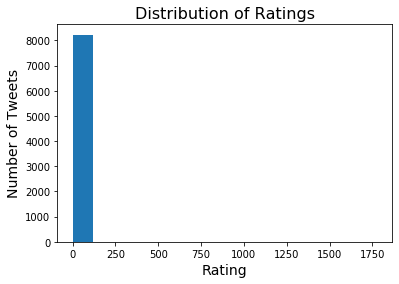

In [234]:
archive_clean['rating_numerator'].plot(kind = 'hist', bins = 15)

#plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

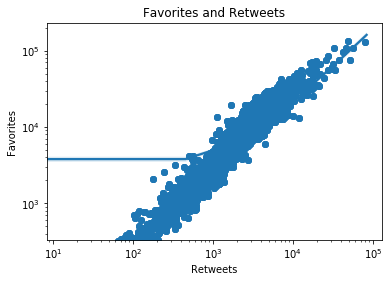

In [137]:
g = sns.regplot(x=archive_clean.retweet_count, y=archive_clean.favorite_count)
plt.title("Favorites and Retweets")
plt.xlabel('Retweets')
plt.ylabel('Favorites')

plt.yscale("log")
plt.xscale("log")

fig = g.get_figure()
fig.savefig('scatterplot.png')

In [144]:
np.corrcoef(archive_clean.retweet_count, archive_clean.favorite_count)

array([[1.        , 0.79047608],
       [0.79047608, 1.        ]])

In [134]:
archive_clean.retweet_count.describe()

count    8292.000000 
mean     2976.089243 
std      5053.982915 
min      16.000000   
25%      634.000000  
50%      1408.000000 
75%      3443.000000 
max      79515.000000
Name: retweet_count, dtype: float64

In [135]:
archive_clean.favorite_count.describe()

count    8292.000000  
mean     8556.718283  
std      12096.451921 
min      0.000000     
25%      1674.000000  
50%      3864.000000  
75%      10937.000000 
max      132810.000000
Name: favorite_count, dtype: float64

There is a positive, strong relationship between favorite and retweet counts with correlation (r= 0.79). if the number of favorites increased for a tweet, the number of retweets can expect increased and vice versa.

In [231]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8236 entries, 0 to 8291
Data columns (total 28 columns):
tweet_id                      8236 non-null object
in_reply_to_status_id         8236 non-null object
in_reply_to_user_id           8236 non-null object
timestamp                     8236 non-null datetime64[ns, UTC]
source                        8236 non-null object
text                          8236 non-null object
retweeted_status_id           8236 non-null object
retweeted_status_user_id      8236 non-null object
retweeted_status_timestamp    316 non-null datetime64[ns, UTC]
expanded_urls                 8236 non-null object
rating_numerator              8236 non-null int64
rating_denominator            8236 non-null int64
name                          8236 non-null object
created_at                    8236 non-null datetime64[ns, UTC]
retweet_count                 8236 non-null int64
favorite_count                8236 non-null int64
jpg_url                       8236 non-null